## Hyperparams Tuner

We can call this class to accomplish hyperparams tuning and return the best_params. This class can be used either independently, or as one of the tasks we conduct in the inner loop of nested cross-alidation. The structure should be consistent with the [FeatureSelector](https://github.com/MenaWANG/ML_toy_examples/blob/main/OOP%20for%20ML%20pipeline/Building%20FeatureSelector.ipynb).

Will work on this after finish building a POC NestedCVTrainer and tested with the FeatureSelector class. 

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, make_scorer
from hyperopt import fmin, tpe, space_eval, Trials, hp
from hyperopt.pyll.base import scope
from sklearn.model_selection import StratifiedKFold
from mlops_class import MLUtils 


In [2]:
class HyperparamsTuner:
    def __init__(self, 
                search_space, 
                scorer,
                max_evals=100,
                estimator=lgb.LGBMClassifier(verbose=-1),
                cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)):
        self.scorer = scorer
        self.max_evals = max_evals
        self.search_space = search_space
        self.estimator = estimator
        self.cv = cv
    
    def select_hyperparams(self, X, y):        
        
        def objective(params):
            
            # define the model by hyperparams
            model = self.estimator.set_params(**params)

            # split by cv and return mean test score
            scores = []
            for train_idx, valid_idx in self.cv.split(X, y):
                X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
                y_train, y_valid = y[train_idx], y[valid_idx]

                model.fit(X_train, y_train)            
                # Predict probabilities on the validation set
                # y_prob = model.predict_proba(X_valid)
                # score = roc_auc_score(y_valid, y_prob[:,1])
                score = self.scorer(model, X_valid, y_valid)
                scores.append(score)
            
            return -np.mean(scores)  

        self.trials = Trials()    
        best = fmin(fn=objective,
                space=self.search_space,
                algo=tpe.suggest,
                max_evals=self.max_evals,
                trials=self.trials)
                
        self.best_params = space_eval(self.search_space, best)
        
        return self.best_params
    
    #TODO: Add a summary_plot() function, utilizing what's captured in trials

In [3]:
# Usage

# dataset for the demo
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")
# custom_scorer
custom_scorer = make_scorer(MLUtils.gini_scorer, greater_is_better=True, needs_proba=True)
search_space = {
    'num_leaves': scope.int(hp.quniform('num_leaves', 10, 50, 1)),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 300, 1)),
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart', 'goss']),
}

# Initialize the FeatureSelector with the desired configuration
custom_tuner = HyperparamsTuner(search_space=search_space,
                                scorer = custom_scorer)

# Select the best features using RFE and cross-validation
best_params = custom_tuner.select_hyperparams(X, y)
print("best_params:", best_params)


100%|██████████| 100/100 [00:36<00:00,  2.77trial/s, best loss: -0.9878069537674224]
best_params: {'boosting_type': 'dart', 'learning_rate': 0.1569239358184807, 'n_estimators': 271, 'num_leaves': 46}


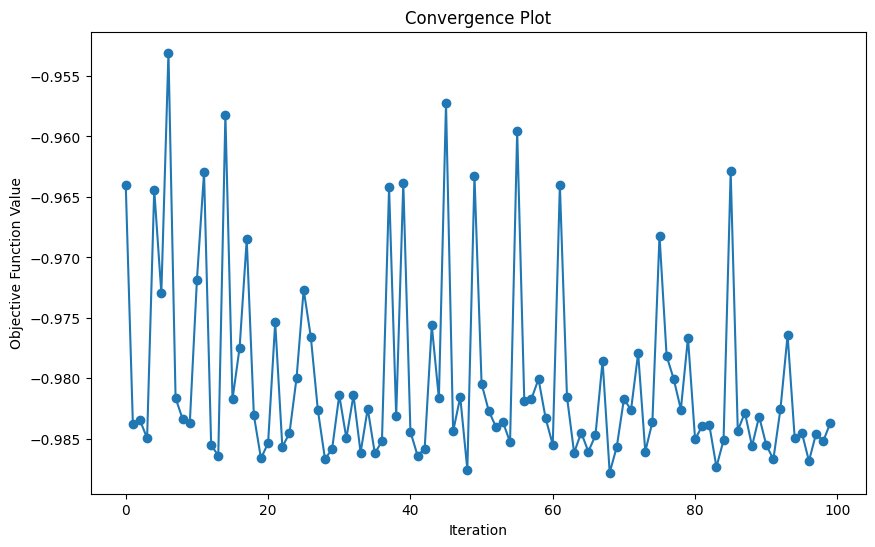

In [13]:
#TODO: Next iteration: add a summary plot to the HyperparamsTuner class, below is a convergence plot
# but a parallel coordinates plot will be very helpful too. 

import matplotlib.pyplot as plt
import seaborn as sns
from hyperopt import Trials

def plot_convergence(trials):
    iteration = [t['tid'] for t in trials.trials]
    loss = [t['result']['loss'] for t in trials.trials]

    plt.figure(figsize=(10, 6))
    plt.plot(iteration, loss, marker='o')
    plt.title('Convergence Plot')
    plt.xlabel('Iteration')
    plt.ylabel('Objective Function Value')
    plt.show()

# Example usage
plot_convergence(custom_tuner.trials)
